# Visualization of Similarity Analysis for llc_modis_curl

In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [2]:
%matplotlib inline

from importlib import reload
import os
import numpy as np
from pkg_resources import resource_filename

import pandas

import h5py
import seaborn as sns
import pandas as pd
#import umap
from ulmo import plotting
from ulmo.ssl.train_util import modis_loader, set_model
from ulmo.ssl.train_util import Params, option_preprocess
from ulmo.ssl import latents_extraction

import torch

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

In [3]:
llc_curl_path = "/home/jovyan/ulmo/ulmo/runs/SSL/llc_ssl_kin/experiments/llc_modis_2012_curl_latents/"
llc_curl_reduced_latents = os.path.join(llc_curl_path, os.listdir(llc_curl_path)[1])

In [4]:
llc_curl_reduced_latents = pd.read_feather(llc_curl_reduced_latents).values

In [31]:
llc_curl_path = "/home/jovyan/ulmo/ulmo/runs/SSL/llc_ssl_kin/experiments/llc_modis_2012_curl_latents/"
llc_curl_latents_file = os.path.join(llc_curl_path, os.listdir(llc_curl_path)[0])

In [32]:
with h5py.File(llc_curl_latents_file, 'r') as f:
    llc_curl_latents = f['valid'][:]

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [6]:
num_samples = llc_curl_reduced_latents.shape[0]
print(num_samples)

635295


In [7]:
point_size = 100.0 / np.sqrt(num_samples)
width, height = 800, 800
dpi = 100

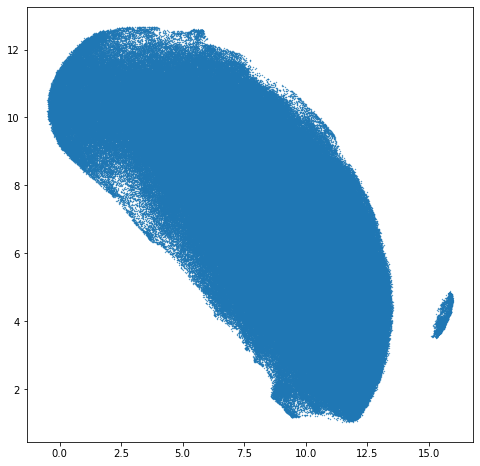

In [8]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(llc_curl_reduced_latents[:, 0], llc_curl_reduced_latents[:, 1], s=point_size)

In [86]:
x_coord = np.argwhere(llc_curl_reduced_latents[:, 0] > 12.5)

In [85]:
y_coord = np.argwhere(llc_curl_reduced_latents[:, 1] < 2)

In [91]:
x_coord[:, 0]

array([     9,     58,     73, ..., 635271, 635276, 635291])

In [90]:
y_coord[:, 0]

array([    10,     55,     74, ..., 635098, 635175, 635226])

In [9]:
llc_modis_curl_path = "/home/jovyan/ulmo/ulmo/runs/SSL/experiments/datasets/llc_kin_dataset/"
llc_modis_curl_file = os.path.join(llc_modis_curl_path, os.listdir(llc_modis_curl_path)[1])

In [ ]:
with h5py.File(llc_modis_curl_file, 'r') as f:
    llc_modis_curl = f['valid'][:]

In [10]:
nbrs = NearestNeighbors(n_neighbors=1024, algorithm='ball_tree').fit(llc_curl_reduced_latents)
distances, indices = nbrs.kneighbors(llc_curl_reduced_latents)

In [96]:
llc_curl_nearest_indices_path = os.path.join(llc_curl_path, 'llc_curl_near_indices.h5')

In [98]:
with h5py.File(llc_curl_nearest_indices_path, 'w') as f:
    f.create_dataset('indices', data=indices)

In [14]:
np.random.seed(0)
indice_sampled = np.random.choice(indices.shape[0], 5)

In [15]:
indice_sets = indices[indice_sampled]
dist_sets = distances[indice_sampled]

In [16]:
indice_sets.shape

(5, 1024)

In [17]:
reduced_latents_subset = []
for i in range(2):
    reduced_latents_subset.append(llc_curl_reduced_latents[indice_sets[i]])

In [18]:
reduced_latents_subset = np.concatenate(reduced_latents_subset, axis=0)

In [19]:
num_samples = llc_curl_reduced_latents.shape[0]
point_size = 100.0 / np.sqrt(num_samples)
width, height = 800, 800
dpi = 100

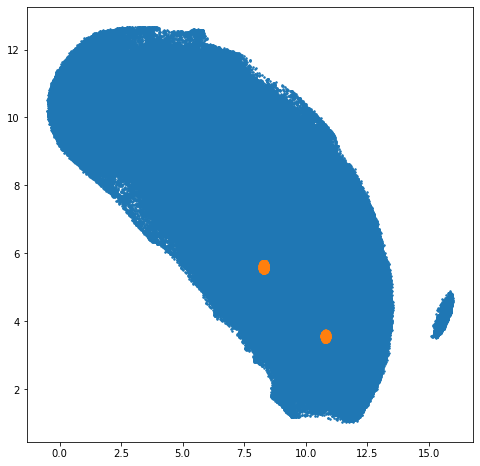

In [21]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(llc_curl_reduced_latents[:, 0], llc_curl_reduced_latents[:, 1], s=point_size)
plt.scatter(reduced_latents_subset[:, 0], reduced_latents_subset[:, 1], s=point_size)

In [22]:
indices_combined = [indices[indice_sampled[0]], indices[indice_sampled[1]]]

In [23]:
indices_combined = np.concatenate(indices_combined, axis=0)

In [33]:
latents_subset = llc_curl_latents[indices_combined]

In [34]:
sim_matrix = cosine_similarity(latents_subset)

In [35]:
sim_vector = np.mean(sim_matrix, axis=1)

In [36]:
sim_exp_vector = np.exp(sim_vector)

<AxesSubplot:ylabel='Count'>

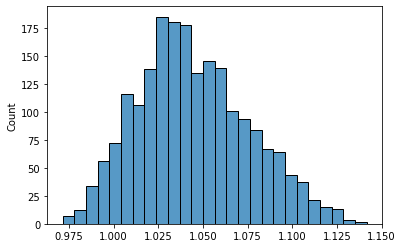

In [37]:
sns.histplot(sim_exp_vector)

<AxesSubplot:ylabel='Count'>

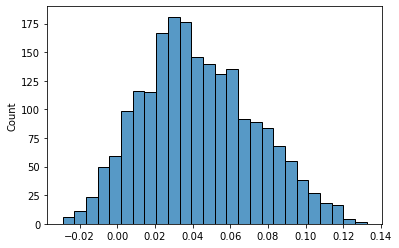

In [38]:
sns.histplot(sim_vector)

<AxesSubplot:ylabel='Count'>

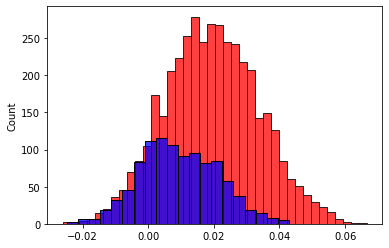

In [64]:
sns.histplot(sim_vector[1024:], color='red')
sns.histplot(sim_vector[:1024], color='blue')

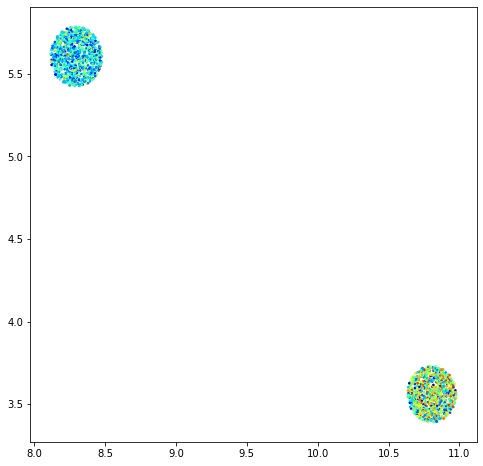

In [45]:
plt.figure(figsize=(width//dpi, height//dpi))
#plt.scatter(llc_curl_reduced_latents[:, 0], llc_curl_reduced_latents[:, 1], s=point_size)
plt.scatter(reduced_latents_subset[:, 0], reduced_latents_subset[:, 1], s=point_size,
            c=sim_exp_vector, cmap='jet')

In [65]:
reduced_latents_subset = []
for i in range(5):
    reduced_latents_subset.append(llc_curl_reduced_latents[indice_sets[i]])

In [66]:
reduced_latents_subset = np.concatenate(reduced_latents_subset, axis=0)

In [61]:
point_size = 100.0 / np.sqrt(num_samples)
width, height = 800, 800
dpi = 100

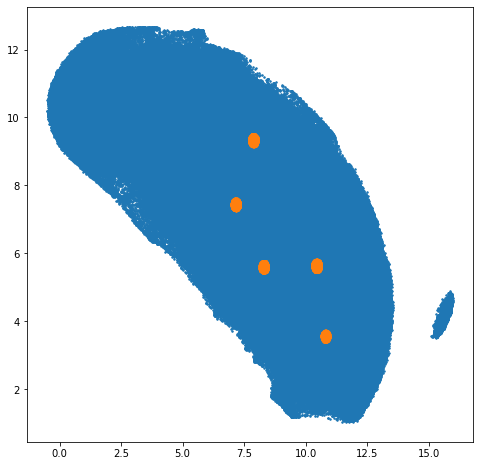

In [48]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(llc_curl_reduced_latents[:, 0], llc_curl_reduced_latents[:, 1], s=point_size)
plt.scatter(reduced_latents_subset[:, 0], reduced_latents_subset[:, 1], s=point_size)

In [67]:
indices_combined = [indices[indice_sampled[i]] for i in range(5)]
indices_combined = np.concatenate(indices_combined, axis=0)

In [68]:
latents_subset = llc_curl_latents[indices_combined]

In [69]:
sim_matrix = cosine_similarity(latents_subset)

In [70]:
sim_vector = np.mean(sim_matrix, axis=1)

In [71]:
sim_exp_vector = np.exp(sim_vector)

<AxesSubplot:ylabel='Count'>

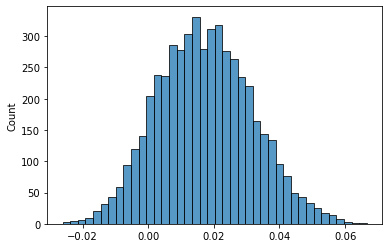

In [72]:
sns.histplot(sim_vector)

<AxesSubplot:ylabel='Count'>

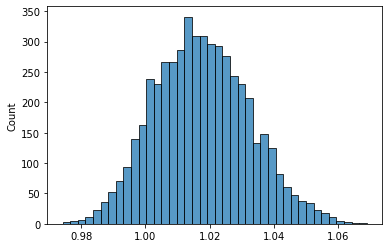

In [73]:
sns.histplot(sim_exp_vector)

<AxesSubplot:ylabel='Count'>

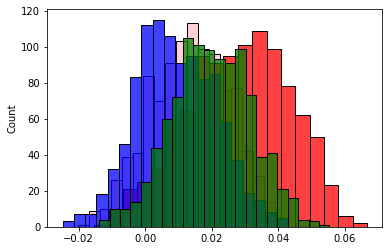

In [81]:
sns.histplot(sim_vector[1024*3: 1024*4], color='pink')
sns.histplot(sim_vector[1024: 2048], color='red')
sns.histplot(sim_vector[: 1024], color='blue')
sns.histplot(sim_vector[1024*3: 1024:4], color='cyan')
sns.histplot(sim_vector[2048: 1024*3], color='green')

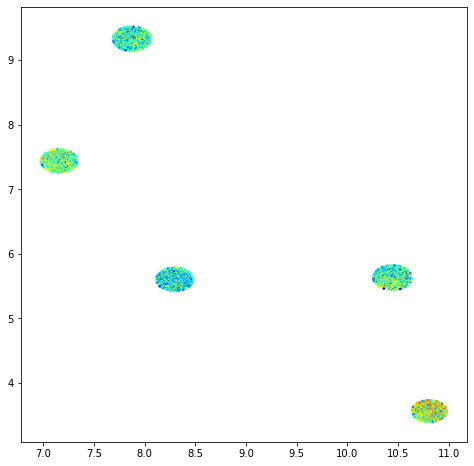

In [56]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(reduced_latents_subset[:, 0], reduced_latents_subset[:, 1], s=point_size,
            c=sim_exp_vector, cmap='jet')

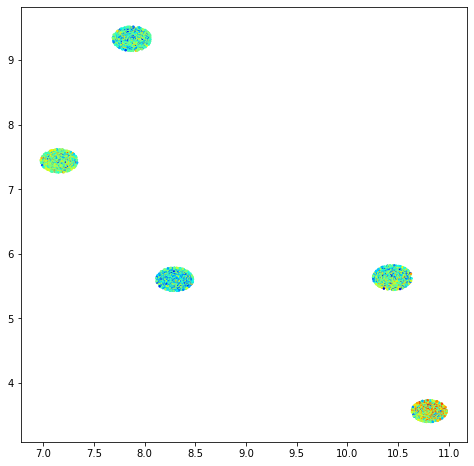

In [57]:
plt.figure(figsize=(width//dpi, height//dpi))
plt.scatter(reduced_latents_subset[:, 0], reduced_latents_subset[:, 1], s=point_size,
            c=sim_vector, cmap='jet')